In [1]:
import tqdm
import numpy as np
import pandas as pd
import torch
import json
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import defaultdict
from transformers import BertTokenizer, EncoderDecoderModel, AutoModelForSequenceClassification

from readers import tg_reader, lenta_reader, ria_reader
from custom_datasets.agency_title_dataset import AgencyTitleDatasetGeneration
from custom_datasets import FullStyleDataset

def first_sent(x, token_id):
    lx = list(x)
    if token_id in x:
        return x[:lx.index(token_id)]
    return x

def reader(path):
    with open(path, 'r') as f:
        for line in f:
            yield json.loads(line.strip())

In [2]:
device = 'cuda'
# device = 'cpu'

In [3]:
tokenizer_path = '/home/aobuhtijarov/models/rubert_cased_L-12_H-768_A-12_pt/'

# BASELINES
joint_baseline_path = '/home/aobuhtijarov/models/joint-baseline/checkpoint-6000/'
ria_baseline_path = '/home/aobuhtijarov/models/ria_baseline/checkpoint-6000/'
lenta_baseline_path = '/home/aobuhtijarov/models/lenta_baseline/checkpoint-6000/'


# STYLE MODELS
joint_style_path = '/home/aobuhtijarov/models/full_style_model/checkpoint-6000/'
ria_style_path = '/home/aobuhtijarov/models/ria_style/checkpoint-6000/'
lenta_style_path = '/home/aobuhtijarov/models/lenta_style/checkpoint-6000/'


# DISCRIMINATOR
## HERE WE USE BEST
discr_model_path = '/home/aobuhtijarov/models/discriminator_on_clusters_from_rubert/'

In [4]:
tokenizer = BertTokenizer.from_pretrained(tokenizer_path, do_lower_case=False, do_basic_tokenize=False)

In [5]:
records = [r for r in tqdm.tqdm(reader('../../datasets/full_lenta_ria.test.jsonl'))]

lenta_records = [
    {'text': r['lenta_text'], 'title': r['lenta_title'], 'agency': 'lenta.ru', 'date': r['lenta_date']} 
    for r in records
]

ria_records = [
    {'text': r['ria_text'], 'title': r['ria_title'], 'agency': 'РИА Новости', 'date': r['lenta_date']} 
    for r in records
]

2000it [00:00, 3380.65it/s]


In [6]:
def text_to_transformer_input(text):
    inputs = tokenizer(
        text,
        add_special_tokens=True,
        max_length=250,
        padding="max_length",
        truncation=True
    )
    
    return {
        'input_ids': torch.LongTensor(inputs['input_ids']).to(device).unsqueeze(0),
        'attention_mask': torch.LongTensor(inputs['attention_mask']).to(device).unsqueeze(0)
    }

def text_to_transformer_input_not_unsqueeze(text):
    inputs = tokenizer(
        text,
        add_special_tokens=True,
        max_length=250,
        padding="max_length",
        truncation=True
    )
    
    return {
        'input_ids': torch.LongTensor(inputs['input_ids']).to(device),
        'attention_mask': torch.LongTensor(inputs['attention_mask']).to(device)
    }

def unsq(x):
    return {
        'input_ids': x['input_ids'].unsqueeze(0),
        'attention_mask': x['attention_mask'].unsqueeze(0),        
    }

In [7]:
generation_args = {
    'decoder_start_token_id': 0,
    'min_length': 7,
    'max_length': 20,
    'num_beams': 6
}

single_lenta_from_ria = []
single_lenta_from_lenta = []
single_ria_from_ria = []
single_ria_from_lenta = []

joint_lenta_from_ria = []
joint_lenta_from_lenta = []
joint_ria_from_ria = []
joint_ria_from_lenta = []

ref_ria = [r['ria_title'] for r in records]
ref_lenta = [r['lenta_title'] for r in records]

In [31]:
ref_clusters = [ [r['ria_title'], r['lenta_title']]  for r in records]

In [8]:
agency_list = ['РИА Новости', 'lenta.ru']
agency_to_special_token_id = {a: tokenizer.vocab[f'[unused{i+1}]'] for i, a in enumerate(agency_list)}
agency_to_discr_target = {a: i for i, a in enumerate(sorted(agency_list))}

In [9]:
def set_target_title(tok_otpt, agency_to_special_token_id, target_agency):
    marker = agency_to_special_token_id[target_agency]

    tok_otpt['input_ids'][2:] = tok_otpt['input_ids'][1:-1].clone()
    tok_otpt['input_ids'][1] = marker

    tok_otpt['attention_mask'][2:] = tok_otpt['attention_mask'][1:-1].clone()
    tok_otpt['attention_mask'][1] = 1

    return tok_otpt

In [10]:
joint_style = EncoderDecoderModel.from_pretrained(joint_style_path)
joint_style.eval()
joint_style.to(device)

with torch.no_grad():
    for i in tqdm.trange(len(records)):
        
        joint_lenta_from_ria.append(joint_style.generate(**unsq(
            set_target_title(text_to_transformer_input_not_unsqueeze(records[i]['ria_text']), 
                             agency_to_special_token_id, 'lenta.ru')
        ),
        **generation_args))
        
        joint_lenta_from_lenta.append(joint_style.generate(**unsq(
            set_target_title(text_to_transformer_input_not_unsqueeze(records[i]['lenta_text']), 
                             agency_to_special_token_id, 'lenta.ru')
        ),
        **generation_args))
        
        
        joint_ria_from_ria.append(joint_style.generate(**unsq(
            set_target_title(text_to_transformer_input_not_unsqueeze(records[i]['ria_text']), 
                             agency_to_special_token_id, 'РИА Новости')
        ),
        **generation_args))
        
        joint_ria_from_lenta.append(joint_style.generate(**unsq(
            set_target_title(text_to_transformer_input_not_unsqueeze(records[i]['lenta_text']), 
                             agency_to_special_token_id, 'РИА Новости')
        ),
        **generation_args))
        
joint_style.cpu();

100%|██████████| 2000/2000 [35:13<00:00,  1.06s/it]


In [11]:
ria_style = EncoderDecoderModel.from_pretrained(ria_style_path)
ria_style.eval()
ria_style.to(device)

with torch.no_grad():
    for i in tqdm.trange(len(records)):
        ria_inp = text_to_transformer_input(records[i]['ria_text'])
        lenta_inp = text_to_transformer_input(records[i]['lenta_text'])
        
        single_ria_from_ria.append(
            ria_style.generate(**ria_inp, **generation_args)
        )
        
        single_ria_from_lenta.append(
            ria_style.generate(**lenta_inp, **generation_args)
        )
        
ria_style.cpu();

100%|██████████| 2000/2000 [16:01<00:00,  2.08it/s]


In [12]:
lenta_style = EncoderDecoderModel.from_pretrained(lenta_style_path)
lenta_style.eval()
lenta_style.to(device)

with torch.no_grad():
    for i in tqdm.trange(len(records)):
        ria_inp = text_to_transformer_input(records[i]['ria_text'])
        lenta_inp = text_to_transformer_input(records[i]['lenta_text'])
        
        single_lenta_from_ria.append(
            lenta_style.generate(**ria_inp, **generation_args)
        )
        
        single_lenta_from_lenta.append(
            lenta_style.generate(**lenta_inp, **generation_args)
        )
        
lenta_style.cpu();

100%|██████████| 2000/2000 [16:01<00:00,  2.08it/s]


In [13]:
def trans_otpt_to_headline(otpt):
    return [
        tokenizer.decode(first_sent(x, tokenizer.sep_token_id), skip_special_tokens=True) for x in otpt
    ][0]

In [14]:
%%time

single_ria_from_ria = [trans_otpt_to_headline(x) for x in single_ria_from_ria]
single_ria_from_lenta = [trans_otpt_to_headline(x) for x in single_ria_from_lenta]
single_lenta_from_ria = [trans_otpt_to_headline(x) for x in single_lenta_from_ria]
single_lenta_from_lenta = [trans_otpt_to_headline(x) for x in single_lenta_from_lenta]

joint_ria_from_ria = [trans_otpt_to_headline(x) for x in joint_ria_from_ria]
joint_ria_from_lenta = [trans_otpt_to_headline(x) for x in joint_ria_from_lenta]
joint_lenta_from_ria = [trans_otpt_to_headline(x) for x in joint_lenta_from_ria]
joint_lenta_from_lenta = [trans_otpt_to_headline(x) for x in joint_lenta_from_lenta]

CPU times: user 9.3 s, sys: 116 ms, total: 9.41 s
Wall time: 9.41 s


## Style Metrics Table

In [38]:
import pandas as pd
import numpy as np

from utils.gen_title_calculate_metrics import calc_metrics

def scalar_from_metrics(m):
    return (m['rl'] + m['r2'] + m['rl']) / 3

### For joint

In [39]:
joint_results = np.zeros((6, 6))

headlines = (
    joint_lenta_from_ria, joint_lenta_from_lenta, ref_lenta, joint_ria_from_ria, joint_ria_from_lenta, ref_ria
)

names = (
    'RIA-Lenta', 'Lenta-Lenta', 'Ref Lenta', 'RIA-RIA', 'Lenta-RIA',  'Ref RIA'
)

for i, h1 in tqdm.tqdm(enumerate(headlines)):
    for j, h2 in enumerate(headlines):
        if type(h1[0]) != list:
            h1 = [[x] for x in h1]
        if type(h2[0]) != str:
            h2 = [x[0] for x in h2]
        
        joint_results[i, j] = scalar_from_metrics(
            calc_metrics(h1, h2, language='ru')
        )

6it [00:47,  8.00s/it]


In [40]:
df = pd.DataFrame(joint_results, columns=names, index=names).round(2)
df

,RIA-Lenta,Lenta-Lenta,Ref Lenta,RIA-RIA,Lenta-RIA,Ref RIA
RIA-Lenta,1.00,0.38,0.27,0.42,0.28,0.27
Lenta-Lenta,0.38,1.00,0.33,0.29,0.45,0.24
Ref Lenta,0.27,0.33,1.00,0.23,0.26,0.27
RIA-RIA,0.42,0.29,0.23,1.00,0.37,0.35
Lenta-RIA,0.28,0.45,0.26,0.37,1.00,0.27
Ref RIA,0.27,0.24,0.27,0.35,0.27,1.00


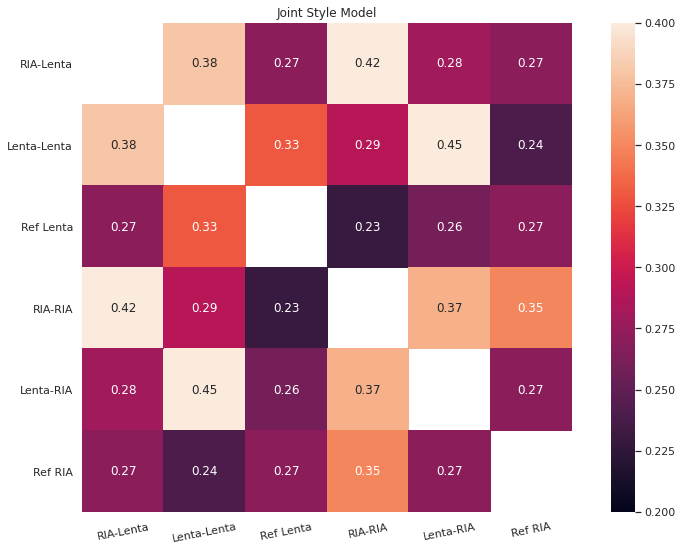

In [41]:
mask = np.zeros((6, 6), dtype=bool)
mask[np.diag_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 9))
    ax = sns.heatmap(df, mask=mask, vmax=.4, vmin=0.2, square=True, annot=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=11)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title('Joint Style Model')
    f.savefig('joint_style_eval.eps', bbox_inches='tight', format='eps')

### For single

In [42]:
single_results = np.zeros((6, 6))

headlines = (
    single_lenta_from_ria, single_lenta_from_lenta, ref_lenta, single_ria_from_ria, single_ria_from_lenta, ref_ria
)

names = (
    'RIA-Lenta', 'Lenta-Lenta', 'Ref Lenta', 'RIA-RIA', 'Lenta-RIA',  'Ref RIA'
)

for i, h1 in tqdm.tqdm(enumerate(headlines)):
    for j, h2 in enumerate(headlines):
        if type(h1[0]) != list:
            h1 = [[x] for x in h1]
        if type(h2[0]) != str:
            h2 = [x[0] for x in h2]
        
        single_results[i, j] = scalar_from_metrics(
            calc_metrics(h1, h2, language='ru')
        )

6it [00:47,  7.84s/it]


In [43]:
df = pd.DataFrame(single_results, columns=names, index=names).round(2)
df

,RIA-Lenta,Lenta-Lenta,Ref Lenta,RIA-RIA,Lenta-RIA,Ref RIA
RIA-Lenta,1.00,0.37,0.25,0.28,0.22,0.23
Lenta-Lenta,0.37,1.00,0.30,0.22,0.28,0.21
Ref Lenta,0.25,0.30,1.00,0.22,0.24,0.27
RIA-RIA,0.28,0.22,0.22,1.00,0.36,0.32
Lenta-RIA,0.22,0.28,0.24,0.36,1.00,0.26
Ref RIA,0.23,0.21,0.27,0.32,0.26,1.00


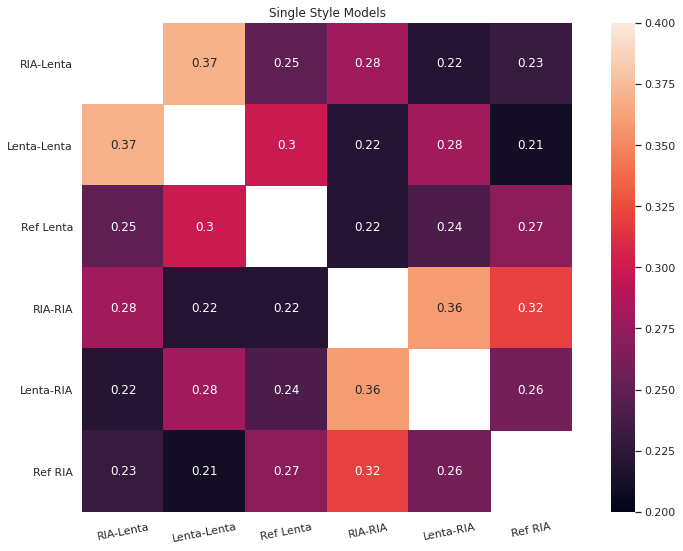

In [44]:
mask = np.zeros((6, 6), dtype=bool)
mask[np.diag_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(14, 9))
    ax = sns.heatmap(df, mask=mask, vmax=.4, vmin=0.2, square=True, annot=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=11)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0) 
    ax.set_title('Single Style Models')
    f.savefig('single_style_eval.eps', bbox_inches='tight', format='eps')    

### Dataset view

In [48]:
train_records = [r for r in tqdm.tqdm(reader('../../datasets/full_lenta_ria.train.jsonl'))]

75362it [00:15, 4886.24it/s]


In [50]:
train_records[73802]

{'lenta_text': 'в одном из ресторанов в псковской области задержали вора в законе по прозвищу паштет. об этом сообщается на сайте мвд россии. 33-летний паштет — гражданин белоруссии — нарушил режим пребывания иностранных граждан. вместе с ним в ресторане, где должна была состояться сходка, было задержано еще 18 человек, имеющих отношение к уголовной среде. в 2013 году суд признал пребывание паштета на территории россии нежелательным, он был депортирован в белоруссию. однако, уклонившись от исполнения постановления суда, он незаконно въехал в рф. в настоящее время задержанный помещен в специальное учреждение временного содержания иностранных граждан областного уфмс до исполнения решения о его депортации и назначении штрафа. паштет, или павел алексеевич, получил титул вора в законе в декабре 2012 года. в январе 2013-го его задержали в московской области во время сходки. у паштета нашли 1,5 грамма кокаина. за хранение наркотиков его приговорили к шести месяцам колонии-поселения. после отб

In [70]:
train_records[8]

{'lenta_text': 'председательство в обсе (организация по безопасности и сотрудничеству в европе) с 1 января 2010 года перешло к казахстану. об этом сообщает пресс-служба международной организации. ранее обсе возглавляла греция. казахстан стал первым государством центральной азии, получившим председательство в обсе. кроме того, это первая постсоветская республика, выполняющая эту роль. министр иностранных дел и госсекретарь казахстана канат саудабаев пообещал, что страна приложит все усилия для укрепления безопасности и углубления сотрудничества "от ванкувера до владивостока". саудабаев также поблагодарил своего предшественника, грека георгиоса папандреу (george papandreou) за отличную работу на посту председателя обсе. на 14 января назначено заседание постоянного совета обсе. руководство международной организации соберется в вене.',
 'lenta_title': 'председательство в обсе перешло к казахстану',
 'lenta_date': '2010-01-01 10:00',
 'ria_text': ' мадрид/брюссель, 1 янв - риа новости. рота

## Style Discriminator eval

In [75]:
cross_style_model_path = '/home/aobuhtijarov/models/lenta_ria_cross_style/'
# cross_style_model_path = '/home/aobuhtijarov/models/lenta_ria_cross_style_from_pretrained/'

vanilla_prepend_path = '/home/aobuhtijarov/models/style_gen_title_from_pretrained/'

In [73]:
cross_style_model_lenta = []
cross_style_model_ria = []

cross_style_model = EncoderDecoderModel.from_pretrained(cross_style_model_path)
cross_style_model.eval()
cross_style_model.to(device)

with torch.no_grad():
    for i in tqdm.trange(len(records)):
        ria_inp = text_to_transformer_input(records[i]['ria_text'])
        lenta_inp = text_to_transformer_input(records[i]['lenta_text'])
        
        cross_style_model_lenta.append(
            cross_style_model.generate(**ria_inp, **generation_args)
        )
        
        cross_style_model_ria.append(
            cross_style_model.generate(**lenta_inp, **generation_args)
        )
        
cross_style_model.cpu();

100%|██████████| 2000/2000 [15:54<00:00,  2.10it/s]


In [76]:
vanilla_prepend_lenta_from_ria = []
vanilla_prepend_lenta_from_lenta = []
vanilla_prepend_ria_from_ria = []
vanilla_prepend_ria_from_lenta = []

vanilla_prepend_model = EncoderDecoderModel.from_pretrained(vanilla_prepend_path)
vanilla_prepend_model.eval()
vanilla_prepend_model.to(device)

with torch.no_grad():
    for i in tqdm.trange(len(records)):
        vanilla_prepend_lenta_from_ria.append(vanilla_prepend_model.generate(**unsq(
            set_target_title(text_to_transformer_input_not_unsqueeze(records[i]['ria_text']), 
                             agency_to_special_token_id, 'lenta.ru')
        ),
        **generation_args))
        
        vanilla_prepend_lenta_from_lenta.append(vanilla_prepend_model.generate(**unsq(
            set_target_title(text_to_transformer_input_not_unsqueeze(records[i]['lenta_text']), 
                             agency_to_special_token_id, 'lenta.ru')
        ),
        **generation_args))
        
        
        vanilla_prepend_ria_from_ria.append(vanilla_prepend_model.generate(**unsq(
            set_target_title(text_to_transformer_input_not_unsqueeze(records[i]['ria_text']), 
                             agency_to_special_token_id, 'РИА Новости')
        ),
        **generation_args))
        
        vanilla_prepend_ria_from_lenta.append(vanilla_prepend_model.generate(**unsq(
            set_target_title(text_to_transformer_input_not_unsqueeze(records[i]['lenta_text']), 
                             agency_to_special_token_id, 'РИА Новости')
        ),
        **generation_args))
        
vanilla_prepend_model.cpu();

100%|██████████| 2000/2000 [31:47<00:00,  1.05it/s]


In [81]:
%%time

cross_style_model_lenta = [trans_otpt_to_headline(x) for x in cross_style_model_lenta]
cross_style_model_ria = [trans_otpt_to_headline(x) for x in cross_style_model_ria]

vanilla_prepend_lenta_from_ria = [trans_otpt_to_headline(x) for x in vanilla_prepend_lenta_from_ria]
vanilla_prepend_lenta_from_lenta = [trans_otpt_to_headline(x) for x in vanilla_prepend_lenta_from_lenta]
vanilla_prepend_ria_from_ria = [trans_otpt_to_headline(x) for x in vanilla_prepend_ria_from_ria]
vanilla_prepend_ria_from_lenta = [trans_otpt_to_headline(x) for x in vanilla_prepend_ria_from_lenta]

CPU times: user 6.62 s, sys: 48 ms, total: 6.67 s
Wall time: 6.66 s


In [82]:
def get_discr_res(ria_zag, lenta_zag, mode='SOFT'):
    # Vanilla discriminator
    
    inputs_ria = tokenizer(
        ria_zag,
        add_special_tokens=True,
        max_length=48,
        padding="max_length",
        truncation=True
    )

    inputs_lenta = tokenizer(
        lenta_zag,
        add_special_tokens=True,
        max_length=48,
        padding="max_length",
        truncation=True
    )

    logits_ria = discriminator(input_ids=torch.LongTensor(inputs_ria['input_ids']).to(device).unsqueeze(0), 
                           attention_mask=torch.LongTensor(inputs_ria['attention_mask']).to(device).unsqueeze(0))[0][0]
    pred_ria = torch.argmax(logits_ria).item()

    logits_lenta = discriminator(input_ids=torch.LongTensor(inputs_lenta['input_ids']).to(device).unsqueeze(0), 
                           attention_mask=torch.LongTensor(inputs_lenta['attention_mask']).to(device).unsqueeze(0))[0][0]
    pred_lenta = torch.argmax(logits_lenta).item()

    if mode == 'HARD':
        return int(pred_ria == agency_to_discr_target['РИА Новости'] and \
                       pred_lenta == agency_to_discr_target['lenta.ru'])
    elif mode == 'SOFT':
        return int(logits_ria[agency_to_discr_target['lenta.ru']] < \
                       logits_lenta[agency_to_discr_target['lenta.ru']])
    assert False

In [85]:
discriminator = AutoModelForSequenceClassification.from_pretrained(discr_model_path)
discriminator.eval()
discriminator.to(device)

results = {
    'single': {
        'from ria': 0,
        'from lenta': 0,
        'both cross': 0,
        'both direct': 0,
    },
    'joint': {
        'from ria': 0,
        'from lenta': 0,
        'both cross': 0,
        'both direct': 0,
    },
    'vanilla prepend': {
        'from ria': 0,
        'from lenta': 0,
        'both cross': 0,
        'both direct': 0,
    },
    'cross': {
        'both cross': 0,
    }
}

with torch.no_grad():
    for i in tqdm.trange(len(records)):
        # Single
        ria_zag_from_lenta = single_ria_from_lenta[i]
        ria_zag_from_ria = single_ria_from_ria[i]

        lenta_zag_from_ria = single_lenta_from_ria[i]
        lenta_zag_from_lenta = single_lenta_from_lenta[i]

        results['single']['from ria'] += get_discr_res(ria_zag_from_ria, lenta_zag_from_ria)
        results['single']['from lenta'] += get_discr_res(ria_zag_from_lenta, lenta_zag_from_lenta)
        results['single']['both cross'] += get_discr_res(ria_zag_from_lenta, lenta_zag_from_ria)
        results['single']['both direct'] += get_discr_res(ria_zag_from_ria, lenta_zag_from_lenta)
    
        # Joint
        ria_zag_from_lenta = joint_ria_from_lenta[i]
        ria_zag_from_ria = joint_ria_from_ria[i]

        lenta_zag_from_ria = joint_lenta_from_ria[i]
        lenta_zag_from_lenta = joint_lenta_from_lenta[i]

        results['joint']['from ria'] += get_discr_res(ria_zag_from_ria, lenta_zag_from_ria)
        results['joint']['from lenta'] += get_discr_res(ria_zag_from_lenta, lenta_zag_from_lenta)
        results['joint']['both cross'] += get_discr_res(ria_zag_from_lenta, lenta_zag_from_ria)
        results['joint']['both direct'] += get_discr_res(ria_zag_from_ria, lenta_zag_from_lenta)
        
        # Vanilla prepend
        ria_zag_from_lenta = vanilla_prepend_ria_from_lenta[i]
        ria_zag_from_ria = vanilla_prepend_ria_from_ria[i]

        lenta_zag_from_ria = vanilla_prepend_lenta_from_ria[i]
        lenta_zag_from_lenta = vanilla_prepend_lenta_from_lenta[i]

        results['vanilla prepend']['from ria'] += get_discr_res(ria_zag_from_ria, lenta_zag_from_ria)
        results['vanilla prepend']['from lenta'] += get_discr_res(ria_zag_from_lenta, lenta_zag_from_lenta)
        results['vanilla prepend']['both cross'] += get_discr_res(ria_zag_from_lenta, lenta_zag_from_ria)
        results['vanilla prepend']['both direct'] += get_discr_res(ria_zag_from_ria, lenta_zag_from_lenta)
        
        # Cross
        results['cross']['both cross'] +=  get_discr_res(cross_style_model_ria[i], cross_style_model_lenta[i])
    
discriminator.cpu();

100%|██████████| 2000/2000 [05:52<00:00,  5.68it/s]


In [86]:
disc_df = pd.DataFrame(results)
plot_df = pd.DataFrame({
    'Count': list(disc_df['single']) + list(disc_df['joint']),
    'Model': ['Single'] * 4 + ['Joint'] * 4,
    'Mode': ['From RIA', 'From Lenta', 'Both cross', 'Both direct'] * 2,
})
plot_df['Count'] /= 2000

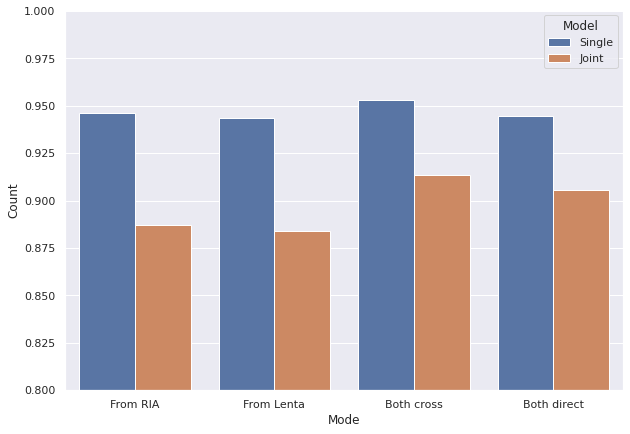

In [87]:
plt.figure(figsize=(10, 7))
sns.barplot(x='Mode', y='Count', hue='Model', data=plot_df)
plt.ylim(0.8)
plt.show()

In [111]:
disc_df

,single,joint,vanilla prepend,cross
from ria,1892,1774,66,NaN
from lenta,1887,1768,93,NaN
both cross,1906,1827,328,1741.0
both direct,1889,1811,1628,NaN


In [114]:
disc_df = pd.DataFrame(results)
plot_df = pd.DataFrame({
    'Count': list(disc_df['single']) + list(disc_df['joint']) + list(disc_df['vanilla prepend']),
    'Model': ['Single'] * 4 + ['Joint'] * 4 + ['Vanilla'] * 4,
    'Mode': ['RIA-RIA\nRIA-Lenta', 'Lenta-RIA\nLenta-Lenta', 'Lenta-RIA\nRIA-Lenta', 'RIA-RIA\nLenta-Lenta'] * 3,
})
plot_df['Count'] /= 2000

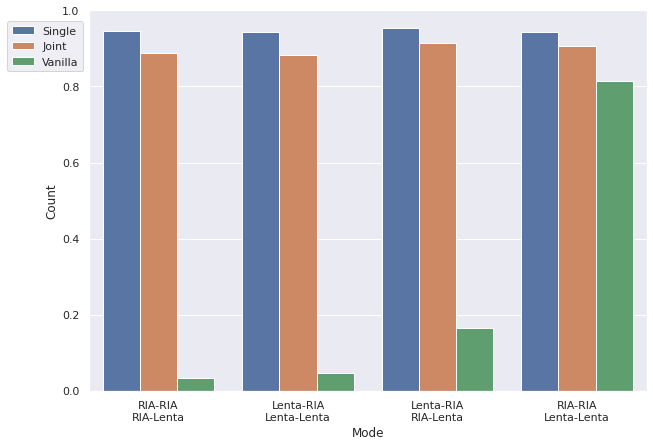

In [115]:
plt.figure(figsize=(10, 7))
sns.barplot(x='Mode', y='Count', hue='Model', data=plot_df)
plt.ylim(0)
plt.legend(loc=1, bbox_to_anchor=(0.0, 0.985))
plt.show()

## Gen Title eval

In [16]:
joint_baseline_hyps_ria = []
joint_baseline_hyps_lenta = []

single_baseline_hyps_ria = []
single_baseline_hyps_lenta = []

In [17]:
joint_baseline = EncoderDecoderModel.from_pretrained(joint_baseline_path)
joint_baseline.eval()
joint_baseline.to(device)

with torch.no_grad():
    for i in tqdm.trange(len(records)):
        ria_inp = text_to_transformer_input(records[i]['ria_text'])
        lenta_inp = text_to_transformer_input(records[i]['lenta_text'])
        
        joint_baseline_hyps_ria.append(
            joint_baseline.generate(**ria_inp, **generation_args)
        )
        
        joint_baseline_hyps_lenta.append(
            joint_baseline.generate(**lenta_inp, **generation_args)
        )

joint_baseline.cpu();

100%|██████████| 2000/2000 [15:26<00:00,  2.16it/s]


In [18]:
ria_baseline = EncoderDecoderModel.from_pretrained(ria_baseline_path)
ria_baseline.eval()
ria_baseline.to(device)

with torch.no_grad():
    for i in tqdm.trange(len(records)):
        ria_inp = text_to_transformer_input(records[i]['ria_text'])
        
        single_baseline_hyps_ria.append(
            ria_baseline.generate(**ria_inp, **generation_args)
        )

ria_baseline.cpu();

100%|██████████| 2000/2000 [08:13<00:00,  4.05it/s]


In [19]:
lenta_baseline = EncoderDecoderModel.from_pretrained(lenta_baseline_path)
lenta_baseline.eval()
lenta_baseline.to(device)

with torch.no_grad():
    for i in tqdm.trange(len(records)):
        lenta_inp = text_to_transformer_input(records[i]['lenta_text'])
        
        single_baseline_hyps_lenta.append(
            lenta_baseline.generate(**lenta_inp, **generation_args)
        )

lenta_baseline.cpu();

100%|██████████| 2000/2000 [07:54<00:00,  4.21it/s]


In [20]:
if type(ref_ria[0]) != list:
    ref_ria = [[x] for x in ref_ria]
if type(ref_lenta[0]) != list:
    ref_lenta = [[x] for x in ref_lenta]

In [21]:
%%time

joint_baseline_hyps_ria = [trans_otpt_to_headline(x) for x in joint_baseline_hyps_ria]
joint_baseline_hyps_lenta = [trans_otpt_to_headline(x) for x in joint_baseline_hyps_lenta]

single_baseline_hyps_ria = [trans_otpt_to_headline(x) for x in single_baseline_hyps_ria]
single_baseline_hyps_lenta = [trans_otpt_to_headline(x) for x in single_baseline_hyps_lenta]

CPU times: user 4.3 s, sys: 28 ms, total: 4.33 s
Wall time: 4.33 s


In [22]:
def metrics_extract(metrics):
    return {
        'Rouge-1': metrics['r1'],
        'Rouge-2': metrics['r2'],
        'Rouge-L': metrics['rl'],
        'Rouge-Mean': (metrics['r1'] + metrics['r2'] + metrics['rl']) / 3,
        'BLEU': metrics['bleu'],
    }

# Naming

**agency of text** - **target agency of headline**

### Joint hyps With Joint baseline

In [32]:
ria_baseline_metrics = calc_metrics(ref_clusters, joint_baseline_hyps_ria, language='ru')
lenta_baseline_metrics = calc_metrics(ref_clusters, joint_baseline_hyps_lenta, language='ru')

ria_style_cross_metrics = calc_metrics(ref_clusters, joint_ria_from_lenta, language='ru')
ria_style_direct_metrics = calc_metrics(ref_clusters, joint_ria_from_ria, language='ru')

lenta_style_cross_metrics = calc_metrics(ref_clusters, joint_lenta_from_ria, language='ru')
lenta_style_direct_metrics = calc_metrics(ref_clusters, joint_lenta_from_lenta, language='ru')

In [33]:
pd.DataFrame(metrics_extract(ria_baseline_metrics), index=['RIA Baseline']).append(
    pd.DataFrame(metrics_extract(ria_style_cross_metrics), index=['Lenta-RIA'])).append(
    pd.DataFrame(metrics_extract(ria_style_direct_metrics), index=['RIA-RIA'])).round(2)

,BLEU,Rouge-1,Rouge-2,Rouge-L,Rouge-Mean
RIA Baseline,0.65,0.48,0.28,0.46,0.41
Lenta-RIA,0.62,0.43,0.23,0.41,0.36
RIA-RIA,0.65,0.47,0.27,0.45,0.40


In [34]:
pd.DataFrame(metrics_extract(lenta_baseline_metrics), index=['Lenta Baseline']).append(
    pd.DataFrame(metrics_extract(lenta_style_cross_metrics), index=['Lenta-Lenta'])).append(
    pd.DataFrame(metrics_extract(lenta_style_direct_metrics), index=['RIA-Lenta'])).round(2)

,BLEU,Rouge-1,Rouge-2,Rouge-L,Rouge-Mean
Lenta Baseline,0.63,0.47,0.27,0.45,0.39
Lenta-Lenta,0.61,0.44,0.23,0.41,0.36
RIA-Lenta,0.63,0.46,0.26,0.44,0.39


### With single baseline

In [35]:
ria_baseline_metrics = calc_metrics(ref_clusters, single_baseline_hyps_ria, language='ru')
lenta_baseline_metrics = calc_metrics(ref_clusters, single_baseline_hyps_lenta, language='ru')

ria_style_cross_metrics = calc_metrics(ref_clusters, single_ria_from_lenta, language='ru')
ria_style_direct_metrics = calc_metrics(ref_clusters, single_ria_from_ria, language='ru')

lenta_style_cross_metrics = calc_metrics(ref_clusters, single_lenta_from_ria, language='ru')
lenta_style_direct_metrics = calc_metrics(ref_clusters, single_lenta_from_lenta, language='ru')

In [36]:
pd.DataFrame(metrics_extract(ria_baseline_metrics), index=['RIA Baseline']).append(
    pd.DataFrame(metrics_extract(ria_style_cross_metrics), index=['Lenta-RIA'])).append(
    pd.DataFrame(metrics_extract(ria_style_direct_metrics), index=['RIA-RIA'])).round(2)

,BLEU,Rouge-1,Rouge-2,Rouge-L,Rouge-Mean
RIA Baseline,0.64,0.46,0.26,0.44,0.39
Lenta-RIA,0.59,0.41,0.21,0.39,0.34
RIA-RIA,0.62,0.44,0.24,0.42,0.37


In [37]:
pd.DataFrame(metrics_extract(lenta_baseline_metrics), index=['Lenta Baseline']).append(
    pd.DataFrame(metrics_extract(lenta_style_cross_metrics), index=['Lenta-Lenta'])).append(
    pd.DataFrame(metrics_extract(lenta_style_direct_metrics), index=['RIA-Lenta'])).round(2)

,BLEU,Rouge-1,Rouge-2,Rouge-L,Rouge-Mean
Lenta Baseline,0.60,0.43,0.23,0.41,0.36
Lenta-Lenta,0.56,0.40,0.20,0.38,0.32
RIA-Lenta,0.58,0.42,0.22,0.40,0.35


## Dumping headlines

In [116]:
from utils.gen_title_calculate_metrics import postprocess

In [124]:
discriminator.to(device);

In [120]:
ref_ria = [x[0] for x in ref_ria]
ref_lenta = [x[0] for x in ref_lenta]

In [125]:
ok_cnt = 0

with open('on_ria.txt', 'w') as f:
    for i in tqdm.trange(len(records)):
        ria_zag = joint_ria_from_ria[i]
        lenta_zag = joint_lenta_from_ria[i]
        
        ria_ref_zag = ref_ria[i]
        lenta_ref_zag = ref_lenta[i]        
            
        inp_ria = tokenizer(ria_zag, 
            add_special_tokens=True, max_length=48,
            padding='max_length', truncation=True
        )
        inp_lenta = tokenizer(lenta_zag, 
            add_special_tokens=True, max_length=48,
            padding='max_length', truncation=True
        )
        
        logits_ria = discriminator(input_ids=torch.LongTensor(inp_ria['input_ids']).cuda().unsqueeze(0), 
                           attention_mask=torch.LongTensor(inp_ria['attention_mask']).cuda().unsqueeze(0))[0]
        logits_lenta = discriminator(input_ids=torch.LongTensor(inp_lenta['input_ids']).cuda().unsqueeze(0), 
                           attention_mask=torch.LongTensor(inp_lenta['attention_mask']).cuda().unsqueeze(0))[0]            
        ria_pred = torch.argmax(logits_ria).item()
        lenta_pred = torch.argmax(logits_lenta).item()

        if not (ria_pred != lenta_pred and \
                ria_pred == agency_to_discr_target['РИА Новости'] and \
                min(logits_ria.max().item(), logits_lenta.max().item()) >= 4.57):
            continue

        ria_ref_zag, ria_zag = postprocess(ria_ref_zag, ria_zag, 'ru', is_multiple_ref=True, lower=True)
        lenta_ref_zag, lenta_zag = postprocess(lenta_ref_zag, lenta_zag, 'ru', is_multiple_ref=True, lower=True)

        f.write('RIA text: ' + records[i]['ria_text'] + '\n\n')
        f.write('RIA Ref headline: ' + ria_ref_zag[0] + '\n')
        f.write('Lenta Ref headline: ' + lenta_ref_zag[0] + '\n\n')

        f.write('RIA Hyp headline: ' + ria_zag + '\n')
        f.write('Lenta Hyp headline: ' + lenta_zag + '\n')

        f.write('\n\n' + '-' * 50 + '\n')
        ok_cnt += 1
        
print(ok_cnt)

100%|██████████| 2000/2000 [00:35<00:00, 56.90it/s]

33


In [ ]:
ok_cnt = 0

with open('on_lenta.txt', 'w') as f:
    for i in tqdm.trange(len(records)):
        ria_zag = joint_ria_from_lenta[i]
        lenta_zag = joint_lenta_from_lenta[i]
        
        ria_ref_zag = ref_ria[i]
        lenta_ref_zag = ref_lenta[i]      
            
        inp_ria = tokenizer(ria_zag, 
            add_special_tokens=True, max_length=48,
            padding='max_length', truncation=True
        )
        inp_lenta = tokenizer(lenta_zag, 
            add_special_tokens=True, max_length=48,
            padding='max_length', truncation=True
        )
        
        logits_ria = discriminator(input_ids=torch.LongTensor(inp_ria['input_ids']).cuda().unsqueeze(0), 
                           attention_mask=torch.LongTensor(inp_ria['attention_mask']).cuda().unsqueeze(0))[0]
        logits_lenta = discriminator(input_ids=torch.LongTensor(inp_lenta['input_ids']).cuda().unsqueeze(0), 
                           attention_mask=torch.LongTensor(inp_lenta['attention_mask']).cuda().unsqueeze(0))[0]            
        ria_pred = torch.argmax(logits_ria).item()
        lenta_pred = torch.argmax(logits_lenta).item()


        if not (ria_pred != lenta_pred and \
                ria_pred == agency_to_discr_target['РИА Новости'] and \
                min(logits_ria.max().item(), logits_lenta.max().item()) >= 4.57):
            continue

        ria_ref_zag, ria_zag = postprocess(ria_ref_zag, ria_zag, 'ru', is_multiple_ref=True, lower=True)
        lenta_ref_zag, lenta_zag = postprocess(lenta_ref_zag, lenta_zag, 'ru', is_multiple_ref=True, lower=True)

        f.write('Lenta text: ' + records[i]['lenta_text'] + '\n\n')
        f.write('RIA Ref headline: ' + ria_ref_zag[0] + '\n')
        f.write('Lenta Ref headline: ' + lenta_ref_zag[0] + '\n\n')

        f.write('RIA Hyp headline: ' + ria_zag + '\n')
        f.write('Lenta Hyp headline: ' + lenta_zag + '\n')

        f.write('\n\n' + '-' * 50 + '\n')
        
        ok_cnt += 1
        
print(ok_cnt)

 61%|██████    | 1224/2000 [00:21<00:13, 58.16it/s]

In [ ]:
discriminator.cpu();

## Watching clusters split

In [140]:
train =  [r for r in tqdm.tqdm(reader('../../datasets/full_lenta_ria.train.jsonl'))]
test = [r for r in tqdm.tqdm(reader('../../datasets/full_lenta_ria.test.jsonl'))]

75362it [00:16, 4526.69it/s]
2000it [00:00, 5875.15it/s]


In [141]:
from collections import Counter

train_texts = [r['ria_text'] for r in train] + [r['lenta_text'] for r in train]
test_texts = [r['ria_text'] for r in test] + [r['lenta_text'] for r in test]

In [142]:
trc = Counter()

for x in train_texts:
    trc.update(x.lower().split())

In [143]:
tc = Counter()

for x in test_texts:
    tc.update(x.lower().split())

In [144]:
trc.most_common(100)[50:]

[('тысяч', 39677),
 ('их', 39408),
 ('года.', 38561),
 ('однако', 37977),
 ('еще', 37619),
 ('сказал', 37316),
 ('данным', 37163),
 ('около', 36350),
 ('под', 35945),
 ('все', 35831),
 ('ее', 34080),
 ('была', 33369),
 ('они', 33155),
 ('сообщил', 31440),
 ('этого', 29242),
 ('словам', 28976),
 ('суд', 27961),
 ('может', 27937),
 ('сша', 27443),
 ('власти', 27228),
 ('или', 26893),
 ('только', 26851),
 ('будут', 26840),
 ('миллионов', 26790),
 ('несколько', 26315),
 ('ссылкой', 26178),
 ('заявил', 26130),
 ('результате', 26066),
 ('чтобы', 25832),
 ('кроме', 25810),
 ('2011', 25788),
 ('том,', 25465),
 ('один', 25234),
 ('пока', 25086),
 ('же', 25045),
 ('так', 24886),
 ('является', 24618),
 ('из-за', 24570),
 ('компании', 24411),
 ('2010', 24297),
 ('глава', 23955),
 ('2012', 23911),
 ('президент', 23905),
 ('где', 23747),
 ('против', 23458),
 ('решение', 22976),
 ('два', 22654),
 ('>>', 22631),
 ('говорится', 22322),
 ('между', 22255)]

In [145]:
tc.most_common(100)[50:]

[('мы', 965),
 ('сша', 932),
 ('украины', 927),
 ('глава', 915),
 ('было', 901),
 ('уже', 895),
 ('более', 887),
 ('их', 872),
 ('еще', 869),
 ('который', 866),
 ('тысяч', 864),
 ('все', 853),
 ('2015', 846),
 ('того,', 828),
 ('под', 791),
 ('они', 784),
 ('может', 768),
 ('около', 761),
 ('сообщил', 747),
 ('этого', 747),
 ('против', 723),
 ('из-за', 715),
 ('новости', 685),
 ('говорится', 684),
 ('ее', 682),
 ('была', 678),
 ('будут', 671),
 ('владимир', 666),
 ('власти', 663),
 ('чтобы', 661),
 ('или', 659),
 ('данным', 654),
 ('решение', 652),
 ('однако', 643),
 ('миллионов', 627),
 ('компании', 613),
 ('словам', 612),
 ('декабря,', 598),
 ('заявил,', 598),
 ('является', 597),
 ('только', 594),
 ('так', 587),
 ('словам,', 582),
 ('1', 565),
 ('она', 554),
 ('же', 553),
 ('быть', 545),
 ('связи', 544),
 ('том,', 541),
 ('10', 540)]